# 自制噪声实验

In [3]:
from data_utils import *
from utils import *
ctx = check_ctx()

import mxnet as mx
import mxnet.ndarray as nd

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 查验噪声生成 PSD


    1. numpy

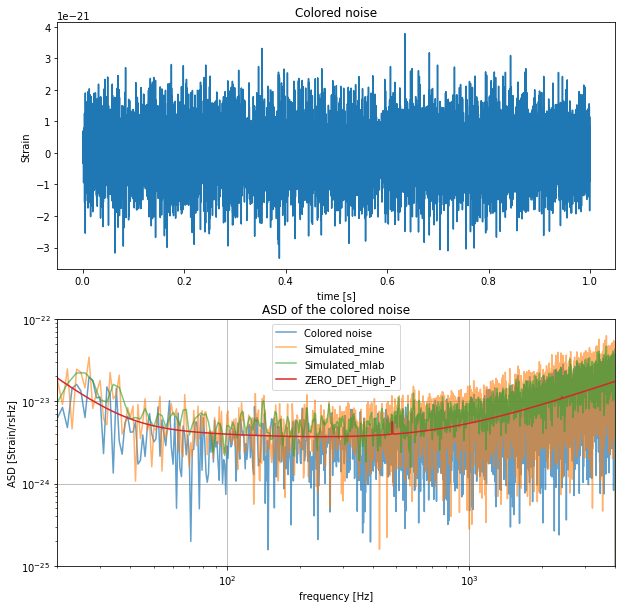

In [4]:
N = 8192
fs = 8192
fmin = 20
fmax = 4000

num = 1

param_noise = Pre_zero( size = (20,8192))
# asd_pos, asd_neg, low_f, high_f, high_f_, size, fs, fmin, fmax = param_noise

noise_sample, psd_zero = TimeseriesFromPSD(param_noise)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, N/fs, N), noise_sample[num])
plt.title('Colored noise')
plt.ylabel('Strain')
plt.xlabel('time [s]')

plt.subplot(2,1,2)
plt.loglog( np.sqrt(psd_zero[num,1:]), label = "Colored noise", alpha=0.7)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(noise_sample, fs)
plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[num,1:]), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample[num], Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mlab", alpha=0.6)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlim(xmin=fmin, xmax = fmax)
plt.ylim((1e-25, 1e-22))
plt.title('ASD of the colored noise')
plt.ylabel('ASD [Strain/rsHz]')
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()
plt.show()

    2. mxnet
    
>GPU only

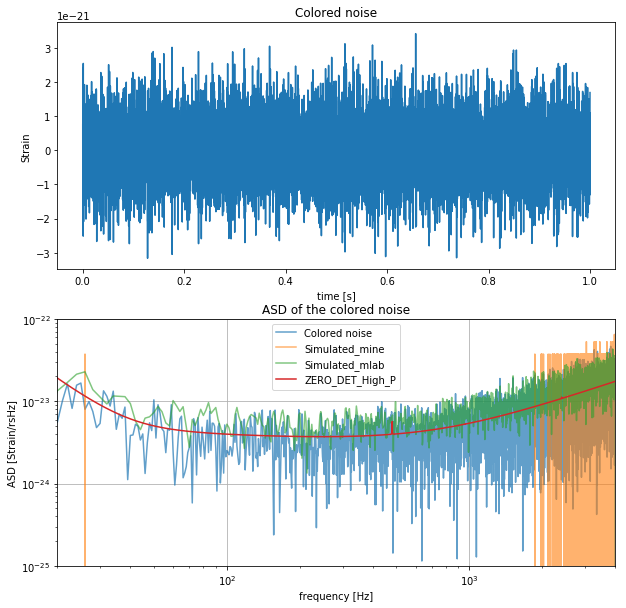

In [11]:
N = 8192
fs = 8192
fmin = 20
fmax = 4000

num = 1

param_noise = Pre_zero(size = (20,8192))
# asd_pos, asd_neg, low_f, high_f, high_f_, size, fs, fmin, fmax = param_noise

noise_sample_nd, psd_zero_nd = TimeseriesFromPSD_nd(param_noise)
noise_sample_nd = noise_sample_nd.asnumpy()
psd_zero_nd = psd_zero_nd.asnumpy()

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(np.linspace(0, N/fs, N), noise_sample_nd[num])
plt.title('Colored noise')
plt.ylabel('Strain')
plt.xlabel('time [s]')


plt.subplot(2,1,2)
plt.loglog( np.sqrt(psd_zero_nd[num,1:]), label = "Colored noise", alpha=0.7)

# Check#1
_, xf_noise_sample, PSD_noise_sample = oneSidedPeriodogram(noise_sample_nd, fs)
plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[num,1:]), label = "Simulated_mine", alpha=0.6)

# Check#2
NFFT = fs//2
# NFFT = 4*fs
psd_window = np.blackman(NFFT)
NOVL = NFFT/2
PSD_noise_sample ,xf_noise_sample= plt.mlab.psd(noise_sample_nd[num], Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)

plt.loglog(xf_noise_sample[1:], np.sqrt(PSD_noise_sample[1:]), label = "Simulated_mlab", alpha=0.6)
plt.loglog(ZERO_DET[:,0],ZERO_DET[:,1], label = "ZERO_DET_High_P")
plt.xlim(xmin=fmin, xmax = fmax)
plt.ylim((1e-25, 1e-22))
plt.title('ASD of the colored noise')
plt.ylabel('ASD [Strain/rsHz]')
plt.xlabel('frequency [Hz]')
plt.grid()
plt.legend()
plt.show()

## 查验噪声生成的效率

In [12]:
param_noise = Pre_zero(size = (13300,8192))

In [13]:
%%time
# MXNet using GPU
noise_sample_nd ,psd_zero_nd = TimeseriesFromPSD_nd(param_noise)

CPU times: user 8 ms, sys: 20 ms, total: 28 ms
Wall time: 9.55 ms


In [14]:
%%time
# Numpy in Floydhub using CPU
noise_sample ,psd_zero = TimeseriesFromPSD(param_noise)

TypeError: type <class 'numpy.ndarray'> not supported

![](https://i.loli.net/2018/09/07/5b926c99063c0.png)


In [11]:
# %%time
# # My Macbook air using CPU
# noise_sample ,psd_zero = TimeseriesFromPSD(param_noise)

## 查验噪声保存的效率

In [9]:
%%time 

nd.save('noise',noise_sample_nd)
!ls -lh noise

-rw-r--r-- 1 root root 416M Aug 15 06:41 noise
CPU times: user 80 ms, sys: 508 ms, total: 588 ms
Wall time: 4.26 s


In [10]:
%%time 

np.save('noise',noise_sample_nd.asnumpy())
!ls -lh noise.npy

-rw-r--r-- 1 root root 416M Aug 15 06:41 noise.npy
CPU times: user 104 ms, sys: 456 ms, total: 560 ms
Wall time: 4.61 s


## 带信噪比的数据集


## 探索 SNR_amp 与 SNR_mf 之间的关系

In [15]:
GW_data = pd.DataFrame(np.load('GW.npy'), index=np.load('GW_index.npy'))
print(GW_data.shape)
GW_data.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'GW.npy'

In [4]:
noise_sample = nd.load('noise')[0]
noise_sample.shape

(13300, 8192)

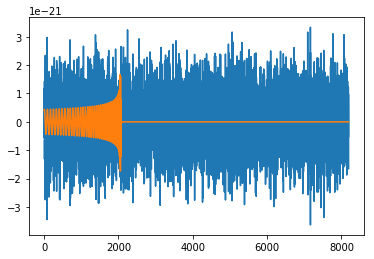

In [5]:
plt.plot(noise_sample.asnumpy()[0])
plt.plot(GW_data.iloc[2])

In [52]:
%%time
_ = nd.array(GW_data, ctx = mx.cpu())

CPU times: user 2.03 s, sys: 1.3 s, total: 3.33 s
Wall time: 4.53 s


In [85]:
signal = GW_data.iloc[:1000]
noise = noise_sample.asnumpy()[:1000,:]
data = noise + signal

print(noise.shape)
print(signal.shape)

(1000, 8192)
(1000, 8192)


In [89]:
%%time 

SNR_MF(data, noise, signal)[:10]

CPU times: user 3.76 s, sys: 826 ms, total: 4.58 s
Wall time: 6.25 s


array([  30.9292102 ,   69.94860303,   71.96676857,   81.95819437,
         87.80996857,   92.57051514,   94.43959868,   93.34676636,
         99.2132796 ,  103.97872588])

In [88]:
%%time 

SNR_MF(data, noise, signal, own_noise=0)[:10]

CPU times: user 2.52 s, sys: 650 ms, total: 3.17 s
Wall time: 3.34 s


array([  42.26856786,   88.92321007,  102.19790478,  113.11402748,
        123.51031578,  129.86668631,  132.40637201,  140.78104728,
        146.00886059,  147.49742371])

In [94]:
noise_psd(noise_sample.asnumpy()[:1,:], fs, 20)

array([  2.98215793e-82,   2.98215793e-82,   2.98215793e-82, ...,
         2.98215793e-82,   2.98215793e-82,   2.98215793e-82])

In [96]:
noise_psd_zero(ZERO_DET, 8192,fs = 8192,low_pass = 20)

array([  3.64606934e-46,   3.64606934e-46,   3.64606934e-46, ...,
         3.64606934e-46,   3.64606934e-46,   3.64606934e-46])

In [98]:
_, xf, yf = oneSidedPeriodogram(noise_sample.asnumpy()[:1,:], fs = 8192)

In [107]:
np.array(yf[:,xf>=0][:,3000], dtype='float64')

array([ 0.])

In [13]:
SNR = 1
# noise = noise_sample.asnumpy()[-10:,:]
noise = noise1.values[-10:,:]
sigma = GW_data.tail(10).max(axis=1) / float(SNR) / noise.std(axis=1)

signal = GW_data.tail(10).div(sigma, axis=0)
data = signal + noise
SNR_mf = SNR_MF(data=data, 
                noise_sample=noise, 
                signal=signal,own_noise=1 , fs=8192, low_pass=20)
SNR_mf

array([  9.56507761,  11.83193968,  14.45292121,  13.90731289,
        17.8875252 ,  19.38513554,  21.72791017,  20.76157738,
        19.11135308,  18.76339307])

array([ 17.62434842,  39.76484647,  40.41199253,  46.43094353,
        49.74178215,  52.30701752,  51.36844489,  52.92582741,
        56.6971194 ,  58.56266822])

In [9]:
noise1 = pd.read_csv('../Noise_data1/LigoNose9_9000_8192_1.csv', index_col=0, nrows = 1000)
print('The shape of the noise1: ', noise1.shape)

The shape of the noise1:  (1000, 8192)


In [28]:
noise1.values

array([[ -1.85141596e-28,   5.72858916e-27,   1.00464327e-26, ...,
         -1.07145223e-23,  -1.23299967e-23,   3.16109331e-24],
       [  5.22865255e-27,   5.39339187e-27,  -1.34459912e-26, ...,
          3.40212754e-24,  -2.25320165e-24,   1.10121462e-23],
       [  7.86119412e-27,   1.17627133e-27,  -3.60243856e-27, ...,
         -1.14593819e-24,   1.23452317e-23,  -1.56199235e-23],
       ..., 
       [  1.37867440e-26,   2.18351145e-27,   5.50107087e-27, ...,
          4.31735217e-24,  -7.18696311e-24,   1.38027359e-24],
       [ -5.60787990e-27,  -5.87118282e-27,  -7.95282151e-27, ...,
          1.67756926e-24,  -5.95905970e-24,   1.35960249e-23],
       [  5.54602931e-27,   1.27125521e-26,   5.57078671e-27, ...,
         -2.05593469e-24,  -1.59259309e-24,   3.61589521e-24]])

In [49]:
scipy.signal.get_window(('tukey',1./8),8192).shape

(8192,)

In [151]:
mf_list1 = []
mf_list2 = []

for l in range(1, 11):
    alpha = l
    signal = GW_data.iloc[:1]#np.random.randn(1,8192)
    noise = noise_sample[:1] #signal.std(axis=1)[0]*np.random.randn(1,8192)
    data = noise + signal/alpha
    mf= SNR_MF(data, noise, signal/alpha)
    mf_list1.append(SNR_MF(data, noise, signal/alpha)[0])

    alpha = mf[0] 
    signal = GW_data.iloc[:1]#np.random.randn(1,8192)
    noise = noise_sample[:1] #signal.std(axis=1)[0]*np.random.randn(1,8192)

    data = noise + signal/alpha
    mf_list2.append(SNR_MF(data, noise, signal/alpha)[0])
    

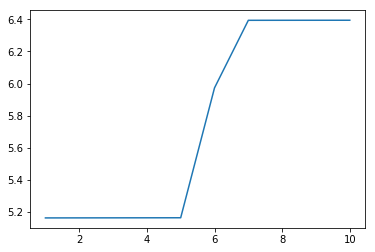

In [152]:
plt.plot(range(1,11), mf_list2)

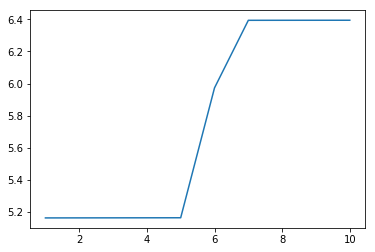

In [153]:
plt.plot(range(1,11), mf_list2)

In [142]:
mf_list

[5.1637345691276879,
 5.1635390932336271,
 5.1635026929709289,
 5.163489927252666,
 5.1634840122830035,
 5.1634807970946017,
 5.1634788575633994,
 5.1634775983197905,
 5.1634767347708488,
 5.1634761169579475]

In [114]:
signal = GW_data.iloc[:1]/mf[0]**2#np.random.randn(1,8192)
noise = noise_sample[:1] #signal.std(axis=1)[0]*np.random.randn(1,8192)

data = noise + signal
mf= SNR_MF(data, noise, signal)
mf[0]

5.1637834617908291

In [75]:
# signal = GW_data.sample(1)#np.random.randn(1,8192)
signal = GW_data.iloc[:1]#np.random.randn(1,8192)
noise = signal.std(axis=1)[0]*np.random.randn(1,8192)#noise_sample[:1]

SNR_MF_list = []
SNR_MF_list2 = []
b_list = []
corr_list = []
for b in range(1, 11):
#         b = np.sqrt(b* signal.max(axis=1)[0] / noise.std())
    data = noise + signal/b
    signal /= b
    mf= SNR_MF(data, noise, signal)
    SNR_MF_list.append(mf[0])
    b_list.append(1/b)
    corr_list.append(np.corrcoef(signal, noise)[0][1])

In [76]:
SNR_MF_list

[83.147121200825765,
 41.553735806547756,
 13.824812210362404,
 4.9131075080811444,
 4.9128111967329984,
 4.912749465202138,
 4.9127388826539891,
 4.9127373393657168,
 4.9127371433926035,
 4.9127371213456286]

In [16]:
dd = nd.random_uniform(shape=(2,10),ctx = mx.gpu(0))
dd


[[ 0.32977498  0.43025011  0.70026755  0.77781075  0.29912937  0.39169419
   0.85030746  0.72038603  0.11062211  0.01445556]
 [ 0.62574261  0.54391116  0.52563101  0.94359356  0.26070136  0.97510064
   0.90819627  0.84426492  0.45200205  0.42338121]]
<NDArray 2x10 @gpu(0)>

In [17]:
# data = np.random.normal(0,1,(3,4))
out = mx.contrib.ndarray.fft(dd)

In [45]:
ss = out.asnumpy()[:,::2] + out.asnumpy()[:,1::2]*1j 


True

array([ 4.62469816+0.j        , -0.84444833-0.53582382j,
       -0.65400386-1.23247707j,  0.71189785+0.50909579j,
        0.14532778-0.06220025j, -0.04449511+0.j        ,
        0.14532778+0.06220025j,  0.71189785-0.50909579j,
       -0.65400386+1.23247707j, -0.84444833+0.53582382j], dtype=complex64)

In [44]:
tt = np.fft.fft(dd.asnumpy())
tt[0]

array([ 4.62469810 +0.00000000e+00j, -0.84444828 -5.35823849e-01j,
       -0.65400389 -1.23247713e+00j,  0.71189783 +5.09095707e-01j,
        0.14532774 -6.22002775e-02j, -0.04449517 +3.88578059e-16j,
        0.14532774 +6.22002775e-02j,  0.71189783 -5.09095707e-01j,
       -0.65400389 +1.23247713e+00j, -0.84444828 +5.35823849e-01j])

In [19]:
!ls ../input/gw_colored8192

GW_test_full.csv		      GW_train_full.csv
GW_test_m112_m267.19999999999999.csv  GW_train_m111_m271.5.csv
GW_test_m130_m272.0.csv		      GW_train_m129_m272.5.csv


In [ ]:
data_GW_train = pd.read_csv('../input/gw_colored8192/GW_train_full.csv', index_col=0)
print('The shape of data_GW_train: ' , data_GW_train.shape)

noise1 = pd.read_csv('../input/noise1/LigoNose9_9000_8192_1.csv', index_col=0)
print('The shape of the noise1: ', noise1.shape)

noise_train = pd.read_csv('../input/noise2/LigoNose9_9000_8192_3.csv', index_col=0)
print('The shape of the noise_train: ', noise_train.shape)